## Modelo 1

Se cargan las librerías.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator

from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score
import seaborn as sns

Se cargan los datos procesados.

In [2]:
segmentos = []

# Leer los archivos CSV segmentados y almacenarlos en la lista
for i in range(0,3):
    segmento = pd.read_csv(f'../data/processed/segmento_{i+1}.csv')
    segmentos.append(segmento)
# Concatenar los DataFrames de los segmentos en uno solo
df1 = pd.concat(segmentos, ignore_index=True)

Se separa el test del Dataframe original no balanceado para asegurar que los datos nuevos serán similares a los reales a predecir, manteniendo proporción en los datos

In [3]:
# Crear las variables para features y target
X = df1[['amt', 'city_pop', 'distancia', 'fraudes_por_Categoria',
       'fraudes_por_estado', 'fraudes_por_edad', 'fraudes_por_hora',
       'fraudes_por_día']]
y = df1['is_fraud']

# Separamos una muestra del DataFrame para probar el modelo
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size = 0.1,
                                                   random_state=0, stratify=y)


Una vez obtenido el test, se pasa a balancear los datos, tanto para aligerar la carga del entrenamiento, como para intentar que el modelo prediga mejor la clase minoritaría.

In [52]:
# Aplicamos undersampling a los datos
rus = RandomUnderSampler()

X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Separamos el nuevo conjunto en X e y
X_under = X_resampled
y_under = y_resampled

Se separa en train y test.

In [36]:
# Volvemos a separar en test y train para que el test original y los datos del undersample no contaminen a examinar
# _train_und, X_test_und, y_train_und, y_test_und = train_test_split(X_under,
#                                                    y_under,
#                                                    test_size = 0.2,
#                                                    random_state=0)

In [4]:
from sklearn.neighbors import LocalOutlierFactor

# Crear el objeto LOF
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.06)

# Ajustar el modelo a los datos
lof.fit(X)

# Obtener las etiquetas de los outliers (-1: outlier, 1: inlier)
predictions = lof.fit_predict(X)
predictions[predictions == 1] = 0
predictions[predictions == -1] = 1

In [8]:
predictions.shape

(1296675,)

Con un GridSearch, se hiperparametriza un GradientBoostingClassifier.

In [53]:
# Definir el pipeline
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("selectkbest", SelectKBest()),
    ("classifier", GradientBoostingClassifier())
])

# Definir los parámetros del GridSearchCV
gb_params = {
    'selectkbest__k': np.arange(2, 8),
    'classifier__loss': ['log_loss', 'exponential'],
    'classifier__learning_rate': [0.1, 0.01, 0.001],
    'classifier__max_depth': np.arange(6, 9),
    'classifier__min_samples_leaf': np.arange(4, 7),
    'classifier__max_features': np.arange(6, 9),
}
# Crear el GridSearchCV
clf = GridSearchCV(estimator=pipe, param_grid=gb_params, cv=3, scoring="roc_auc")

# Ajustar el GridSearchCV
clf.fit(X_resampled, y_resampled)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selectkbest', SelectKBest()),
                                       ('classifier',
                                        GradientBoostingClassifier())]),
             param_grid={'classifier__learning_rate': [0.1, 0.01, 0.001],
                         'classifier__loss': ['log_loss', 'exponential'],
                         'classifier__max_depth': array([6, 7, 8]),
                         'classifier__max_features': array([6, 7, 8]),
                         'classifier__min_samples_leaf': array([4, 5, 6]),
                         'selectkbest__k': array([2, 3, 4, 5, 6, 7])},
             scoring='roc_auc')

In [54]:
clf.best_params_

{'classifier__learning_rate': 0.1,
 'classifier__loss': 'log_loss',
 'classifier__max_depth': 6,
 'classifier__max_features': 8,
 'classifier__min_samples_leaf': 6,
 'selectkbest__k': 3}

In [6]:
predictions = lof.predict(y)

AttributeError: predict is not available when novelty=False, use fit_predict if you want to predict on training data. Use novelty=True if you want to use LOF for novelty detection and predict on new unseen data.

[[1212822   76347]
 [   6052    1454]]


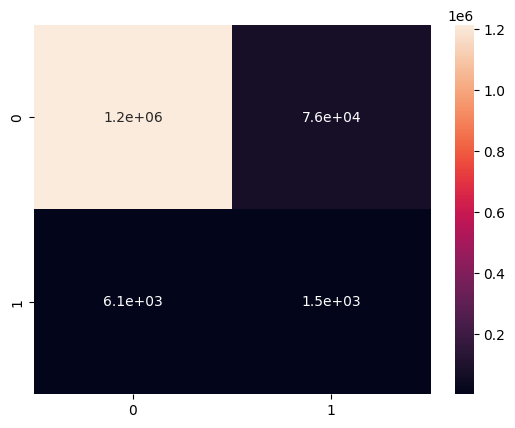

In [13]:
c_matrix = confusion_matrix(y, predictions)
print(c_matrix)
sns.heatmap(c_matrix, annot=True);

In [57]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score

In [14]:
precision_score(y, predictions)

0.018688705800696648

In [15]:
recall_score(y, predictions)

0.19371169730881962

In [16]:
roc_auc_score(y, predictions)

0.567244913237874

In [61]:
# Definir el pipeline
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("selectkbest", SelectKBest()),
    ("classifier", GradientBoostingClassifier())
])

# Definir los parámetros del GridSearchCV
gb_params = {
    'selectkbest__k': np.arange(5, 8),
    'classifier__loss': ['log_loss', 'exponential'],
    'classifier__learning_rate': [0.1, 0.01],
    'classifier__max_depth': np.arange(7,8),
    'classifier__min_samples_split': np.arange(4,5),
    'classifier__min_samples_leaf': np.arange(3, 6),
    'classifier__max_features': np.arange(4, 7),
}

# Crear el GridSearchCV
clf = GridSearchCV(estimator=pipe, param_grid=gb_params, cv=3, scoring="precision")

# Ajustar el GridSearchCV
clf.fit(X_train_und, y_train_und)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selectkbest', SelectKBest()),
                                       ('classifier',
                                        GradientBoostingClassifier())]),
             param_grid={'classifier__learning_rate': [0.1, 0.01],
                         'classifier__loss': ['log_loss', 'exponential'],
                         'classifier__max_depth': array([7]),
                         'classifier__max_features': array([4, 5, 6]),
                         'classifier__min_samples_leaf': array([3, 4, 5]),
                         'classifier__min_samples_split': array([4]),
                         'selectkbest__k': array([5, 6, 7])},
             scoring='precision')

In [62]:
clf.best_params_

{'classifier__learning_rate': 0.1,
 'classifier__loss': 'log_loss',
 'classifier__max_depth': 7,
 'classifier__max_features': 5,
 'classifier__min_samples_leaf': 3,
 'classifier__min_samples_split': 4,
 'selectkbest__k': 5}

In [63]:
predictions = clf.predict(X_test)

[[125470   3447]
 [    15    736]]


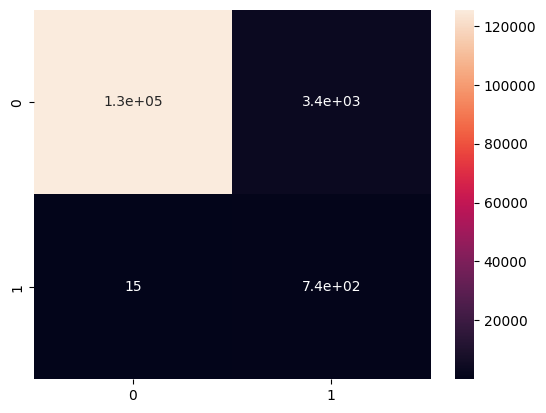

In [64]:
c_matrix = confusion_matrix(y_test, predictions)
print(c_matrix)
sns.heatmap(c_matrix, annot=True);

In [65]:
print("Precision score:", precision_score(y_test, predictions))
print("Recall score:", recall_score(y_test, predictions))
print("ROC AUC score:", roc_auc_score(y_test, predictions))

Precision score: 0.17595027492230456
Recall score: 0.9800266311584553
ROC AUC score: 0.9766442486602023


In [69]:
# Definir el pipeline
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("selectkbest", SelectKBest()),
    ("classifier", GradientBoostingClassifier())
])

gb_params = {
    'selectkbest__k': np.arange(5, 8),
    'classifier__loss': ['log_loss', 'exponential'],
    'classifier__learning_rate': [0.1, 0.01],
    'classifier__max_depth': np.arange(15, 20),
    'classifier__max_features': np.arange(4, 7),
}

# Crear el GridSearchCV
clf = GridSearchCV(estimator=pipe, param_grid=gb_params, cv=3, scoring="roc_auc")

# Ajustar el GridSearchCV
clf.fit(X_train_und, y_train_und)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selectkbest', SelectKBest()),
                                       ('classifier',
                                        GradientBoostingClassifier())]),
             param_grid={'classifier__learning_rate': [0.1, 0.01],
                         'classifier__loss': ['log_loss', 'exponential'],
                         'classifier__max_depth': array([15, 16, 17, 18, 19]),
                         'classifier__max_features': array([4, 5, 6]),
                         'selectkbest__k': array([5, 6, 7])},
             scoring='roc_auc')

In [70]:
clf.best_params_

{'classifier__learning_rate': 0.01,
 'classifier__loss': 'exponential',
 'classifier__max_depth': 16,
 'classifier__max_features': 4,
 'selectkbest__k': 7}

In [71]:
predictions = clf.predict(X_test)

[[125655   3262]
 [    15    736]]


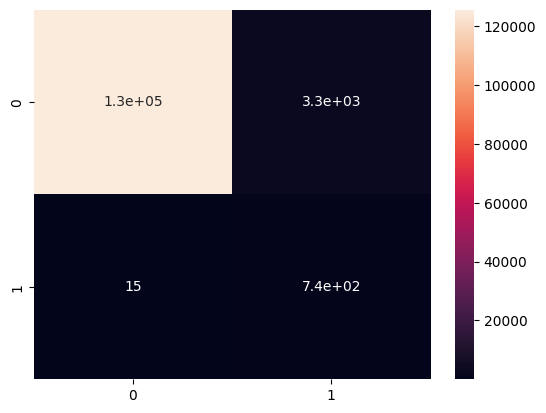

In [72]:
c_matrix = confusion_matrix(y_test, predictions)
print(c_matrix)
sns.heatmap(c_matrix, annot=True);

In [73]:
print("Precision score:", precision_score(y_test, predictions))
print("Recall score:", recall_score(y_test, predictions))
print("ROC AUC score:", roc_auc_score(y_test, predictions))

Precision score: 0.18409204602301152
Recall score: 0.9800266311584553
ROC AUC score: 0.9773617645812988


In [74]:
# Definir el pipeline
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("selectkbest", SelectKBest()),
    ("classifier", GradientBoostingClassifier())
])

gb_params = {
    'selectkbest__k': np.arange(4, 9),
    'classifier__loss': ['log_loss', 'exponential'],
    'classifier__learning_rate': [0.1, 0.01,0.001],
    'classifier__max_depth': np.arange(15, 18),
}

# Crear el GridSearchCV
clf = GridSearchCV(estimator=pipe, param_grid=gb_params, cv=3, scoring="roc_auc")

# Ajustar el GridSearchCV
clf.fit(X_train_und, y_train_und)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selectkbest', SelectKBest()),
                                       ('classifier',
                                        GradientBoostingClassifier())]),
             param_grid={'classifier__learning_rate': [0.1, 0.01, 0.001],
                         'classifier__loss': ['log_loss', 'exponential'],
                         'classifier__max_depth': array([15, 16, 17]),
                         'selectkbest__k': array([4, 5, 6, 7, 8])},
             scoring='roc_auc')

In [39]:
# Para escribir el archivo pickle
with open('../models/Model2/trained_model2.pkl', 'wb') as archivo_salida:
    pickle.dump(clf.best_estimator_, archivo_salida)

# Para escribir el archivo YAML
with open("../models/Model2/model2_config.yaml", "w") as f:
    yaml.dump(clf.best_params_, f)

NameError: name 'pickle' is not defined